In [1]:
# Import statements
import pandas as pd
import subprocess
import os
import json
from IPython.display import display, Image, Markdown

In [2]:
# Hardset vars
dataset_path = "data/processed/labeled_asset_dataset_enriched.csv"
config_path = "config/generation_params.json"

In [3]:
# Load the dataset for analysis, if it is not present, trigger a mlflow run using the default pipeline settings
try:
    df = pd.read_csv(dataset_path)
    print("✅ Dataset loaded.")
except FileNotFoundError:
    print(f"⚠️ {dataset_path} not found. Running MLflow pipeline to generate data...")
    result = subprocess.run(
        ["mlflow", "run", ".", "-e", "pipeline", "--env-manager=local"],
        capture_output=True, text=True, encoding="utf-8", errors="replace"
    )
    # Print the output, but ignore decode errors and replace weird chars
    print(result.stdout)
    if result.returncode != 0:
        print("❌ MLflow pipeline failed to run. Check the error above.")
        raise RuntimeError("MLflow pipeline execution failed")
    if os.path.exists(dataset_path):
        df = pd.read_csv(dataset_path)
        print("✅ Dataset generated and loaded.")
    else:
        raise FileNotFoundError(f"Dataset still not found at {dataset_path} after running pipeline.")

⚠️ data/processed/labeled_asset_dataset_enriched.csv not found. Running MLflow pipeline to generate data...
[DEBUG] Pipeline received config: config/generation_params.json
✅ Enriched dataset written to: data/processed\labeled_asset_dataset_enriched.csv
--- Model Report ---
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      1965
           1       0.54      0.39      0.45       285

    accuracy                           0.88      2250
   macro avg       0.73      0.67      0.69      2250
weighted avg       0.87      0.88      0.87      2250

--- Model Report ---
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      2103
           1       0.10      0.01      0.01       147

    accuracy                           0.93      2250
   macro avg       0.52      0.50      0.49      2250
weighted avg       0.88      0.93      0.90      2250


✅ Dataset generated and loaded.


In [4]:
# Calculate presence rates
total_assets = len(df)
present_inventory = (df["missing_in_inventory"] == 0).sum()
present_ipam = (df["missing_in_ipam"] == 0).sum()
present_all = ((df["missing_in_inventory"] == 0) & (df["missing_in_ipam"] == 0)).sum()

In [5]:
# calculate percentages
pct_inventory = present_inventory / total_assets * 100
pct_ipam = present_ipam / total_assets * 100
pct_all = present_all / total_assets * 100

In [6]:
# Print high level stats of presence per system dataset
print(f"Total Observability Assets: {total_assets:,}")
print(f"Present in Inventory: {present_inventory:,} ({pct_inventory:.1f}%)")
print(f"Present in IPAM: {present_ipam:,} ({pct_ipam:.1f}%)")
print(f"Present in BOTH Inventory and IPAM: {present_all:,} ({pct_all:.1f}%)")

Total Observability Assets: 11,246
Present in Inventory: 9,824 (87.4%)
Present in IPAM: 10,512 (93.5%)
Present in BOTH Inventory and IPAM: 9,181 (81.6%)


In [7]:
# Print table form level stats of presence per system dataset
summary = pd.DataFrame({
    "Metric": ["Present in Inventory", "Present in IPAM", "Present in BOTH"],
    "Count": [present_inventory, present_ipam, present_all],
    "Percent": [pct_inventory, pct_ipam, pct_all]
})
display(summary)

,Metric,Count,Percent
0,Present in Inventory,9824,87.355504
1,Present in IPAM,10512,93.473235
2,Present in BOTH,9181,81.637916


In [8]:
# Display the contents of the generation paramaters to display what failure rates were set at data generation
with open(config_path, "r") as f:
    params = json.load(f)

# Pretty-print as Markdown for notebook display
display(Markdown(f"### Contents of `{config_path}`:"))
display(Markdown(f"```json\n{json.dumps(params, indent=4)}\n```"))

### Contents of `config/generation_params.json`:

```json
{
    "IPAM_REGION_MISSING_PROBS": {
        "northeast": 0.3,
        "northwest": 0.01,
        "central": 0.01,
        "east": 0.02,
        "west": 0.05,
        "southeast": 0.03,
        "southwest": 0.01
    },
    "INVENTORY_MODEL_MISSING_PROBS": {
        "ISR4431": 0.5,
        "SRX345": 0.6,
        "ETX-2": 0.4,
        "MX204": 0.01,
        "NCS540": 0.05,
        "7750 SR-1": 0.01,
        "7280R": 0.03,
        "FSP3000": 0.1,
        "FSP150": 0.1,
        "QFX5120": 0.05,
        "7050X3": 0.02,
        "Catalyst9300": 0.03
    },
    "DEFAULT_MODEL_FAILURE_PROB": 0.1,
    "DEFAULT_REGION_FAILURE_PROB": 0.1
}
```

### Generated Report Images

**inventory\inventory_feature_importance.png**

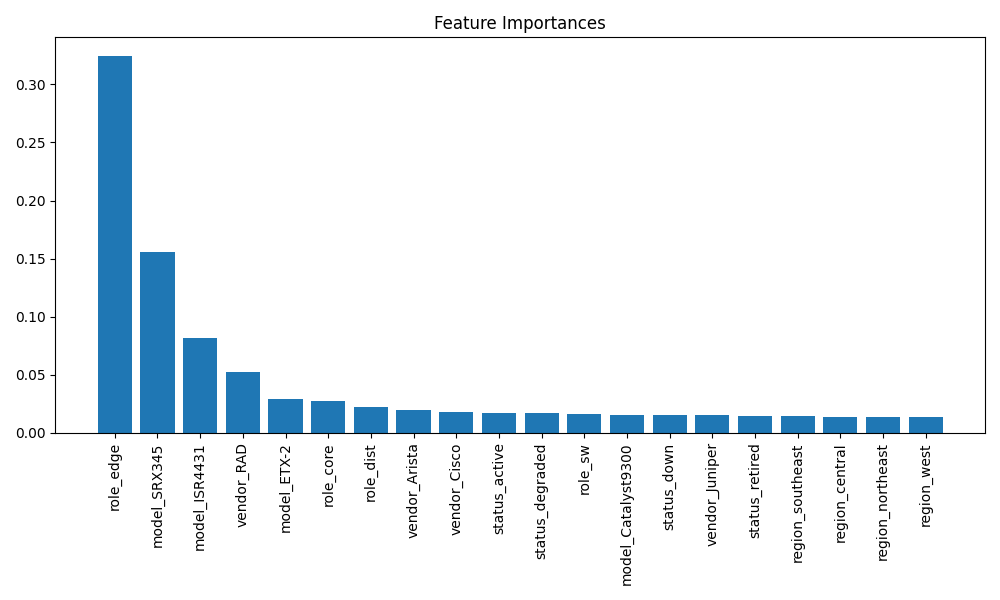

**ipam\ipam_feature_importance.png**

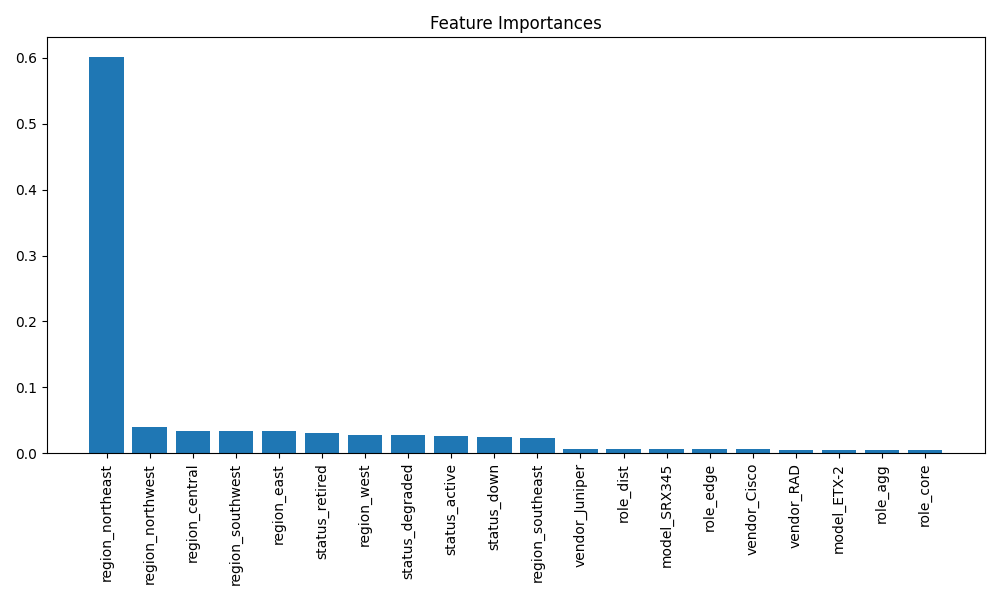

In [9]:
# Display all images in the reports directory (including subdirectories)
reports_dir = "reports"
image_extensions = ('.png', '.jpg', '.jpeg', '.gif')

found_images = []
for root, dirs, files in os.walk(reports_dir):
    for file in files:
        if file.lower().endswith(image_extensions):
            found_images.append(os.path.join(root, file))

if found_images:
    display(Markdown("### Generated Report Images"))
    for img_path in found_images:
        rel_path = os.path.relpath(img_path, reports_dir)
        display(Markdown(f"**{rel_path}**"))
        display(Image(filename=img_path))
else:
    print(f"No report images found in '{reports_dir}' or its subdirectories.")

# Analysis demonstrating alternative data generation scenarios

In [10]:
# Adjusting input variables to alternative config settings
alt_config = "config/alt_scenario_generation_params.json"

In [11]:
# run the alternate training scenario with different config values
steps = [
    # Generate step with alternate config
    [
        "mlflow", "run", ".", "-e", "generate", "--env-manager=local",
        "-P", f"config={alt_config}"
    ],
    # Prepare step
    [
        "mlflow", "run", ".", "-e", "prepare", "--env-manager=local"
    ],
    # Train-both
    [
        "mlflow", "run", ".", "-e", "train-both", "--env-manager=local"
    ]
]

step_names = [
    "Generate (Alternate Config)",
    "Prepare",
    "Train Inventory",
    "Train IPAM",
    "Train Both"
]

for name, cmd in zip(step_names, steps):
    print(f"\n--- Running: {name} ---\n{' '.join(cmd)}\n")
    result = subprocess.run(cmd, capture_output=True, text=True, encoding="utf-8", errors="replace")
    print(result.stdout)
    if result.returncode != 0:
        print(f"❌ Step '{name}' failed. Check the output above.")
        break
    else:
        print(f"✅ Step '{name}' completed.\n")


--- Running: Generate (Alternate Config) ---
mlflow run . -e generate --env-manager=local -P config=config/alt_scenario_generation_params.json


✅ Step 'Generate (Alternate Config)' completed.


--- Running: Prepare ---
mlflow run . -e prepare --env-manager=local

✅ Enriched dataset written to: data/processed\labeled_asset_dataset_enriched.csv

✅ Step 'Prepare' completed.


--- Running: Train Inventory ---
mlflow run . -e train-both --env-manager=local

--- Model Report ---
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1875
           1       0.76      0.84      0.80       375

    accuracy                           0.93      2250
   macro avg       0.86      0.89      0.88      2250
weighted avg       0.93      0.93      0.93      2250

--- Model Report ---
              precision    recall  f1-score   support

           0       0.93      0.98      0.96      2066
           1       0.46      0.21      0.29       184

    accu

In [12]:
# Calculate new presence rates
df = pd.read_csv(dataset_path)

total_assets = len(df)
present_inventory = (df["missing_in_inventory"] == 0).sum()
present_ipam = (df["missing_in_ipam"] == 0).sum()
present_all = ((df["missing_in_inventory"] == 0) & (df["missing_in_ipam"] == 0)).sum()

In [13]:
# calculate new percentages
pct_inventory = present_inventory / total_assets * 100
pct_ipam = present_ipam / total_assets * 100
pct_all = present_all / total_assets * 100

In [17]:
# Print new high level stats of presence per system dataset
print(f"Total Observability Assets: {total_assets:,}")
print(f"Present in Inventory: {present_inventory:,} ({pct_inventory:.1f}%)")
print(f"Present in IPAM: {present_ipam:,} ({pct_ipam:.1f}%)")
print(f"Present in BOTH Inventory and IPAM: {present_all:,} ({pct_all:.1f}%)")

Total Observability Assets: 11,246
Present in Inventory: 9,374 (83.4%)
Present in IPAM: 10,325 (91.8%)
Present in BOTH Inventory and IPAM: 8,613 (76.6%)


In [14]:
# Print new table form level stats of presence per system dataset
summary = pd.DataFrame({
    "Metric": ["Present in Inventory", "Present in IPAM", "Present in BOTH"],
    "Count": [present_inventory, present_ipam, present_all],
    "Percent": [pct_inventory, pct_ipam, pct_all]
})
display(summary)

,Metric,Count,Percent
0,Present in Inventory,9374,83.354081
1,Present in IPAM,10325,91.810421
2,Present in BOTH,8613,76.587231


In [15]:
# Display the contents of the generation paramaters to display what failure rates were set at data generation with the alternet scenario configuration
with open(alt_config, "r") as f:
    params = json.load(f)

# Pretty-print as Markdown for notebook display
display(Markdown(f"### Contents of `{alt_config}`:"))
display(Markdown(f"```json\n{json.dumps(params, indent=4)}\n```"))

### Contents of `config/alt_scenario_generation_params.json`:

```json
{
    "IPAM_REGION_MISSING_PROBS": {
        "northeast": 0.01,
        "northwest": 0.01,
        "central": 0.01,
        "east": 0.02,
        "west": 0.45,
        "southeast": 0.03,
        "southwest": 0.01
    },
    "INVENTORY_MODEL_MISSING_PROBS": {
        "ISR4431": 0.01,
        "SRX345": 0.03,
        "ETX-2": 0.02,
        "MX204": 0.01,
        "NCS540": 0.05,
        "7750 SR-1": 0.01,
        "7280R": 0.03,
        "FSP3000": 0.1,
        "FSP150": 0.82,
        "QFX5120": 0.74,
        "7050X3": 0.02,
        "Catalyst9300": 0.03
    },
    "DEFAULT_MODEL_FAILURE_PROB": 0.1,
    "DEFAULT_REGION_FAILURE_PROB": 0.1
}
```

# Demonstration of change of conditions

Using the updated configuration file, the failure probability weights were adjusted to reflect a higher risk of data quality issues in distribution devices (rather than edge devices) for Inventory, as well as a shift in the region most affected within IPAM.

Under these new scenario parameters, our analysis yielded the following results:

Total Observability Assets: 11,246

Present in Inventory: 9,374 (83.4%)

Present in IPAM: 10,325 (91.8%)

Present in BOTH Inventory and IPAM: 8,613 (76.6%)

This demonstrates how changing system risk assumptions and operational context directly impacts the proportion of complete records, highlighting the importance of scenario-based analysis in data quality audits. By tuning these parameters, we can proactively assess where new risks may emerge and guide targeted remediation efforts.

### Generated Report Images

**inventory\inventory_feature_importance.png**

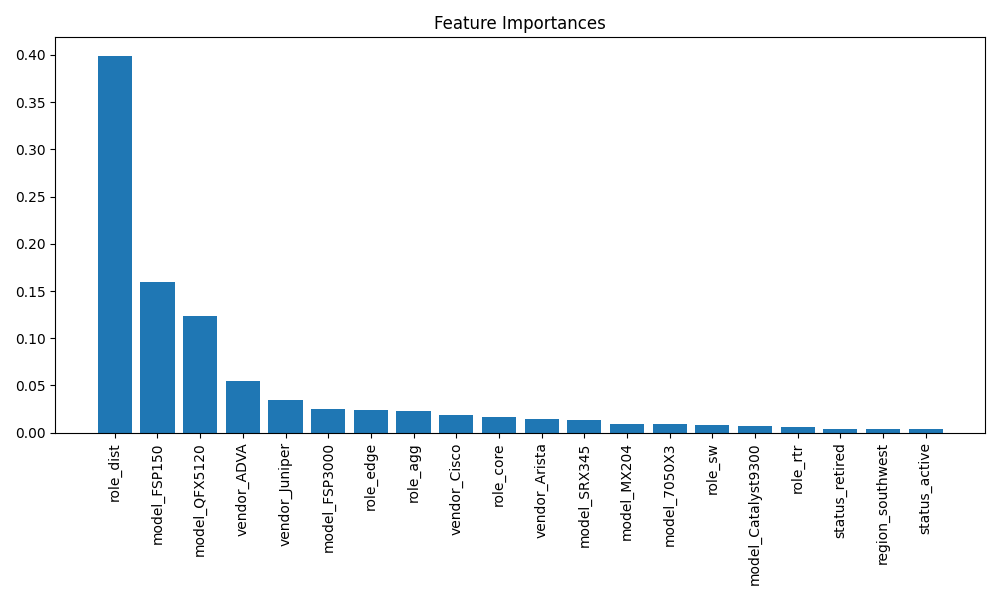

**ipam\ipam_feature_importance.png**

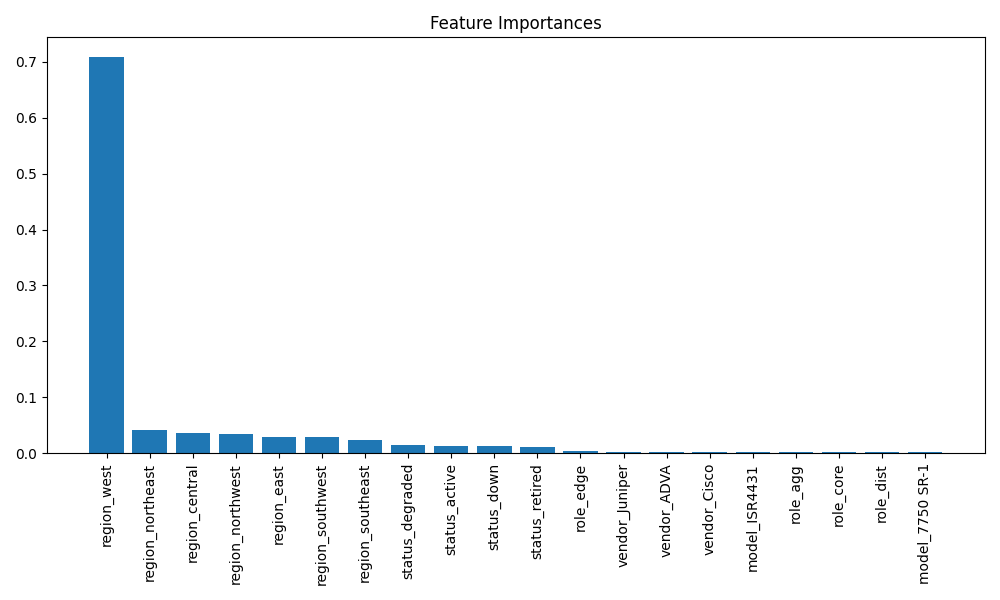

In [16]:
# Display all images in the reports directory (including subdirectories)
reports_dir = "reports"
image_extensions = ('.png', '.jpg', '.jpeg', '.gif')

found_images = []
for root, dirs, files in os.walk(reports_dir):
    for file in files:
        if file.lower().endswith(image_extensions):
            found_images.append(os.path.join(root, file))

if found_images:
    display(Markdown("### Generated Report Images"))
    for img_path in found_images:
        rel_path = os.path.relpath(img_path, reports_dir)
        display(Markdown(f"**{rel_path}**"))
        display(Image(filename=img_path))
else:
    print(f"No report images found in '{reports_dir}' or its subdirectories.")

# Conclusion

This analysis confirms that the asset presence rate across systems meets and exceeds the 75% threshold required to proceed with the security audit project. Out of 11,246 observability assets, 9,824 (87.4%) were found in the Inventory system and 10,512 (93.5%) were found in IPAM, with 9,181 assets (81.6%) present in both systems.

Beyond validating data completeness, we leveraged a random forest supervised model to identify which asset characteristics most strongly drive missing records. With these insights, our team can now focus audit efforts on the specific processes, automation, or staff actions most likely to cause data gaps. This data-driven approach not only supports immediate project goals but also lays the groundwork for long-term improvements in asset data quality and system reliability.